<a href="https://colab.research.google.com/github/ViaAnthroposBenevolentia/ACW/blob/main/SIS4/ACW_SIS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title ##Install necessary requirements
%pip install -q matplotlib control numpy pandas tabulate scipy ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.7 MB/s eta 0:00:00


In [2]:
# @title #Importing necessary libraries
import control as ct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tabulate import tabulate
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
# @title #Functions for creating transfer function, generating time vector, and getting step response
def create_transfer_function():
    """Define and return the transfer function G_k(s)."""
    numerator = [2200000]
    denominator = [2.4, 1400, 2300000]
    G_k = ct.TransferFunction(numerator, denominator)
    return G_k

G_k = create_transfer_function()

def generate_time_vector(start=0, end=0.025, num_points=20*1000):
    """Generate a time vector from start to end with num_points points."""
    return np.linspace(start, end, num_points)

def get_step_response(system, time):
    """Generate the step response of the transfer function/system over time."""
    time, response = ct.step_response(system, T=time)
    return time, response

In [4]:
# @title #Function to annotate given response
def annotate_step_response(ax, time, response, info, color_set_index=0, prefix=''):
    """
    Annotate the step response plot with metrics such as rise time,
    settling time, overshoot, etc., using customizable color sets.

    Parameters:
    - ax: `matplotlib.axes.Axes`
        Matplotlib Axes object where the response is plotted.
    - time: `np.ndarray`
        Array of time values.
    - response: `np.ndarray`
        Array of response values corresponding to the time array.
    - info: `dict`
        Dictionary containing step response metrics, expected keys:
        'SteadyStateValue', 'RiseTime', 'SettlingTime',
        'PeakTime', 'Peak', and 'Overshoot'.
    - color_set: `dict`, optional
        Dictionary specifying colors for different annotations. Expected keys:
        'steady_state', 'peak', 'settling', 'rise', 'input'.
        If `None`, a default color set is used.
    - prefix: `str`, optional
        Prefix string to differentiate annotations when multiple color sets are used.
        This prefix is added to legend labels and tick labels.
    """

    # Helper function for safe label creation with prefix
    def safe_label(value, label_template):
        return f"{prefix} " + label_template.format(value) if not np.isnan(value) else ""

    # Define multiple color sets with unique prefixes
    color_sets = [
      {
          'steady_state': 'r',
          'peak': 'm',
          'settling': 'b',
          'rise': 'g',
          'input': 'black'
      },
      {
          'steady_state': 'c',
          'peak': 'y',
          'settling': 'k',
          'rise': 'orange',
          'input': 'grey'
      },
      {
          'steady_state': '#FF5733',
          'peak': '#33FF57',
          'settling': '#3357FF',
          'rise': '#F1C40F',
          'input': '#8E44AD'
      }
    ]

    color_set = color_sets[color_set_index]

    # Validate that all required colors are provided
    required_keys = ['steady_state', 'peak', 'settling', 'rise', 'input']
    for key in required_keys:
        if key not in color_set:
            raise ValueError(f"Color set missing required key: '{key}'")

    # Define color variables from the selected color set
    color_steady_state = color_set['steady_state']
    color_peak = color_set['peak']
    color_settling = color_set['settling']
    color_rise = color_set['rise']
    color_input = color_set['input']

    # Define offset variables for annotations
    arrow_offset_time = time[-1] * 0.02
    label_offset_time = time[-1] * 0.2

    # Safely extract metrics from the info dictionary
    ss_value = info.get('SteadyStateValue', np.nan)
    rise_time = info.get('RiseTime', np.nan)
    settling_time = info.get('SettlingTime', np.nan)
    peak_time = info.get('PeakTime', np.nan)
    peak_value = info.get('Peak', np.nan)
    overshoot = info.get('Overshoot', np.nan)

    # Calculate steady-state error
    ss_error = abs(1 - ss_value) * 100

    # Steady-state lines
    ax.axhline(y=ss_value, color=color_steady_state, linestyle='--', label=f'{prefix} Steady-State Value')
    ax.axhline(y=1, color=color_input, linestyle='--', label=f'{prefix} Input Step')

    # Annotate Steady-State Error
    x_pos = time[-1] * 0.98
    ax.annotate(
        '', xy=(x_pos, 1), xytext=(x_pos, ss_value),
        arrowprops=dict(arrowstyle='<->', color='black')
    )
    ax.annotate(
        f"\n{prefix}SS Error:{ss_error:.2f}%", xy=(x_pos, 1),
        xytext=(x_pos - label_offset_time, 1 + arrow_offset_time),
        arrowprops=dict(arrowstyle='->', color='black')
    )

    # Rise time thresholds
    threshold_10 = 0.1 * ss_value
    threshold_90 = 0.9 * ss_value

    # Indices for 10% and 90% rise
    try:
        index_10 = next(i for i, r in enumerate(response) if r >= threshold_10)
        time_10 = time[index_10]
    except StopIteration:
        time_10 = np.nan
        print("Warning: Response never reaches 10% of steady-state value.")

    try:
        index_90 = next(i for i, r in enumerate(response) if r >= threshold_90)
        time_90 = time[index_90]
    except StopIteration:
        time_90 = np.nan
        print("Warning: Response never reaches 90% of steady-state value.")

    if not np.isnan(time_10) and not np.isnan(time_90):
        # Plot rise time markers
        ax.vlines(x=[time_10, time_90], ymin=0, ymax=[threshold_10, threshold_90],
                  color=color_rise, linestyle='--')
        ax.hlines(y=[threshold_10, threshold_90], xmin=0, xmax=[time_10, time_90],
                  color=color_rise, linestyle='--')
        ax.plot([time_10, time_90], [threshold_10, threshold_90], 'go')

        # Annotate Rise Time
        y_arrow = threshold_10
        ax.annotate(
            '', xy=(time_90, y_arrow), xytext=(time_10, y_arrow),
            arrowprops=dict(arrowstyle='<->', color='black')
        )
        ax.text(
            (time_10 + time_90) / 2, y_arrow + 0.02,
            f"{prefix}Rise Time:\n{rise_time:.4f}s", ha='center'
        )

    # Peak annotations
    if not (np.isnan(peak_time) or np.isnan(peak_value)):
        ax.vlines(x=peak_time, ymin=0, ymax=peak_value, color=color_peak, linestyle='--', label=f'{prefix} Peak Time')
        ax.hlines(y=peak_value, xmin=0, xmax=peak_time, color=color_peak, linestyle='--')
        ax.plot(peak_time, peak_value, 'mo')

        # Annotate Overshoot
        if peak_value > ss_value:
            x_os = time[len(time)//20] if len(time) > 0 else np.nan
            if not np.isnan(x_os):
                ax.annotate(
                    '', xy=(x_os, peak_value), xytext=(x_os, ss_value),
                    arrowprops=dict(arrowstyle='<->', color='black')
                )
                ax.text(
                    x_os - arrow_offset_time, (peak_value + ss_value) / 2,
                    f"{prefix}Overshoot", rotation=90, va='center'
                )
            ax.text(
                peak_time + arrow_offset_time, peak_value - 0.02,
                f"{prefix}Overshoot: {overshoot:.2f}%", color=color_peak
            )

    # Settling time annotation
    if not np.isnan(settling_time):
        try:
            settling_index = next(i for i, t in enumerate(time) if t >= settling_time)
            settling_value = response[settling_index]
        except StopIteration:
            settling_index = -1
            settling_value = response[-1]
            print("Warning: Settling time exceeds the time array range.")

        ax.vlines(x=settling_time, ymin=0, ymax=settling_value, color=color_settling, linestyle='--', label=f'{prefix} Settling Time')
        ax.plot(settling_time, settling_value, 'bo')

        y_st = ss_value * 0.7
        ax.annotate(
            '', xy=(settling_time, y_st), xytext=(0, y_st),
            arrowprops=dict(arrowstyle='<->', color='black')
        )
        ax.text(
            settling_time / 3, y_st + 0.02,
            f"{prefix}Settling Time: {settling_time:.3f}s"
        )

    # Custom ticks and labels with NaN checks
    padding = 0.03
    ticks_y = [threshold_10, threshold_90, ss_value, 1 + padding, peak_value]
    ticks_x = [time_10, time_90, peak_time, settling_time, time[-1]]

    ticklabels_y = [
        safe_label(threshold_10, "10% Rise: {:.3f}"),
        safe_label(threshold_90, "90% Rise: {:.3f}"),
        safe_label(ss_value, "SS Value: {:.3f}"),
        f"{prefix} Setpoint: 1" if prefix else "Setpoint: 1",
        safe_label(peak_value, "\nPeak Value: {:.3f}") if not np.isnan(peak_value) and abs(peak_value - 1) > 0.005 else f"\n{prefix}Peak Value ~ 1"
    ]

    ticklabels_x = [
        safe_label(time_10, "{:.4f}s"),
        safe_label(time_90, "{:.4f}s"),
        safe_label(peak_time, "{:.4f}s"),
        safe_label(settling_time, "{:.3f}s"),
        f"{prefix} {time[-1]:.3f}s" if prefix else f"{time[-1]:.3f}s"
    ]

    # Clean tick labels by removing empty strings
    ticklabels_y_clean = [label for label in ticklabels_y if label]
    ticklabels_x_clean = [label for label in ticklabels_x if label]

    ticks_y_clean = [tick for tick in ticks_y if not np.isnan(tick)]
    ticks_x_clean = [tick for tick in ticks_x if not np.isnan(tick)]

    ax.set_yticks(ticks_y_clean)
    ax.set_xticks(ticks_x_clean)
    ax.set_yticklabels(ticklabels_y_clean)
    ax.set_xticklabels(ticklabels_x_clean)

    # Handle legend to avoid duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())


In [5]:
# @title #Function to plot Step Response
def plot_step_response(time, response, info, title="Step Response", ylabel="Response", annotate=False, show_metrics=False):
    """
    Plot the step response and apply annotations.

    Parameters:
    - time: Array of time values.
    - response: Array of response values.
    - info: Dictionary containing step response metrics.
    - title: Title of the plot.
    - ylabel: Y-axis label.
    """
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.plot(time, response, linewidth=3, label='Response')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(True)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    if annotate:
      annotate_step_response(ax, time, response, info)
    if show_metrics:
      compute_and_display_metrics(info)
    plt.show()

In [6]:
# @title #Function to display response's metrics in a table
def compute_and_display_metrics(info):
    """Compute and display the step response metrics."""
    metrics = {
        'Metric': [
            'Rise Time', 'Settling Time', 'Settling Min', 'Settling Max',
            'Overshoot', 'Undershoot', 'Peak', 'Peak Time',
            'Steady-State Value', 'Steady-State Error'
        ],
        'Value': [
            round(info.get('RiseTime', np.nan), 3),
            round(info.get('SettlingTime', np.nan), 3),
            round(info.get('SettlingMin', np.nan), 3),
            round(info.get('SettlingMax', np.nan), 3),
            round(info.get('Overshoot', np.nan), 3),
            round(info.get('Undershoot', np.nan), 3),
            round(info.get('Peak', np.nan), 3),
            round(info.get('PeakTime', np.nan), 3),
            round(info.get('SteadyStateValue', np.nan), 3),
            round(abs(1 - info.get('SteadyStateValue', np.nan)), 3)
        ]
    }

    df_metrics = pd.DataFrame(metrics)
    print(tabulate(df_metrics, headers='keys', tablefmt='pretty', floatfmt=".3f"))

    # Optionally, save the metrics to a CSV file
    # df_metrics.to_csv('csv/step.csv', index=False)


In [7]:
# @title #Function for comparing Open Loop with Closed Loop with PID (or P, I, D, PI, PD, etc.) controller
def compare_open_with_PID(G_k, time, Kp, Ki, Kd, annotate_closed=False, annotate_open=False, show_closed_metrics=False, show_open_metrics=False, prefix=''):
    """
    Compare the open-loop step response with the closed-loop response
    using a manually finetuned PID controller, plotting both responses
    on the same figure.
    """
    # Kp => Proportional gain
    # Ki => Integral gain
    # Kd => Derivative gain

    # Create the PID controller transfer function
    controller = ct.TransferFunction([Kd, Kp, Ki], [1, 0])

    # Closed-loop transfer function with unity feedback
    G_cl = ct.feedback(controller * G_k, 1)

    # Compute the step responses
    time_open, response_open = ct.step_response(G_k, T=time)
    time_closed, response_closed = ct.step_response(G_cl, T=time)

    # Compute step response info
    info_open = ct.step_info(G_k)
    info_closed = ct.step_info(G_cl)

    # Plot both responses on the same figure
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.plot(time_open, response_open, linewidth=2, label='Open-Loop Response')
    ax.plot(time_closed, response_closed, linewidth=2, label='Closed-Loop Response with PID')
    ax.set_title('Comparison of Open-Loop and Closed-Loop Step Responses', fontsize=14)
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('Response', fontsize=14)
    ax.grid(True)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Annotate Open and Closed Loop Responses
    if annotate_open:
      annotate_step_response(ax, time_open, response_open, info_open, prefix='Op:')
    if annotate_closed:
      annotate_step_response(ax, time_closed, response_closed, info_closed, prefix=prefix, color_set_index=2)

    if show_closed_metrics:
      compute_and_display_metrics(info_closed)
    if show_open_metrics:
      compute_and_display_metrics(info_open)

    ax.legend()
    plt.show()


+---+--------------------+--------+
|   |       Metric       | Value  |
+---+--------------------+--------+
| 0 |     Rise Time      | 0.001  |
| 1 |   Settling Time    | 0.011  |
| 2 |    Settling Min    | 0.822  |
| 3 |    Settling Max    | 1.315  |
| 4 |     Overshoot      | 37.508 |
| 5 |     Undershoot     |  0.0   |
| 6 |        Peak        | 1.315  |
| 7 |     Peak Time      | 0.003  |
| 8 | Steady-State Value | 0.957  |
| 9 | Steady-State Error | 0.043  |
+---+--------------------+--------+


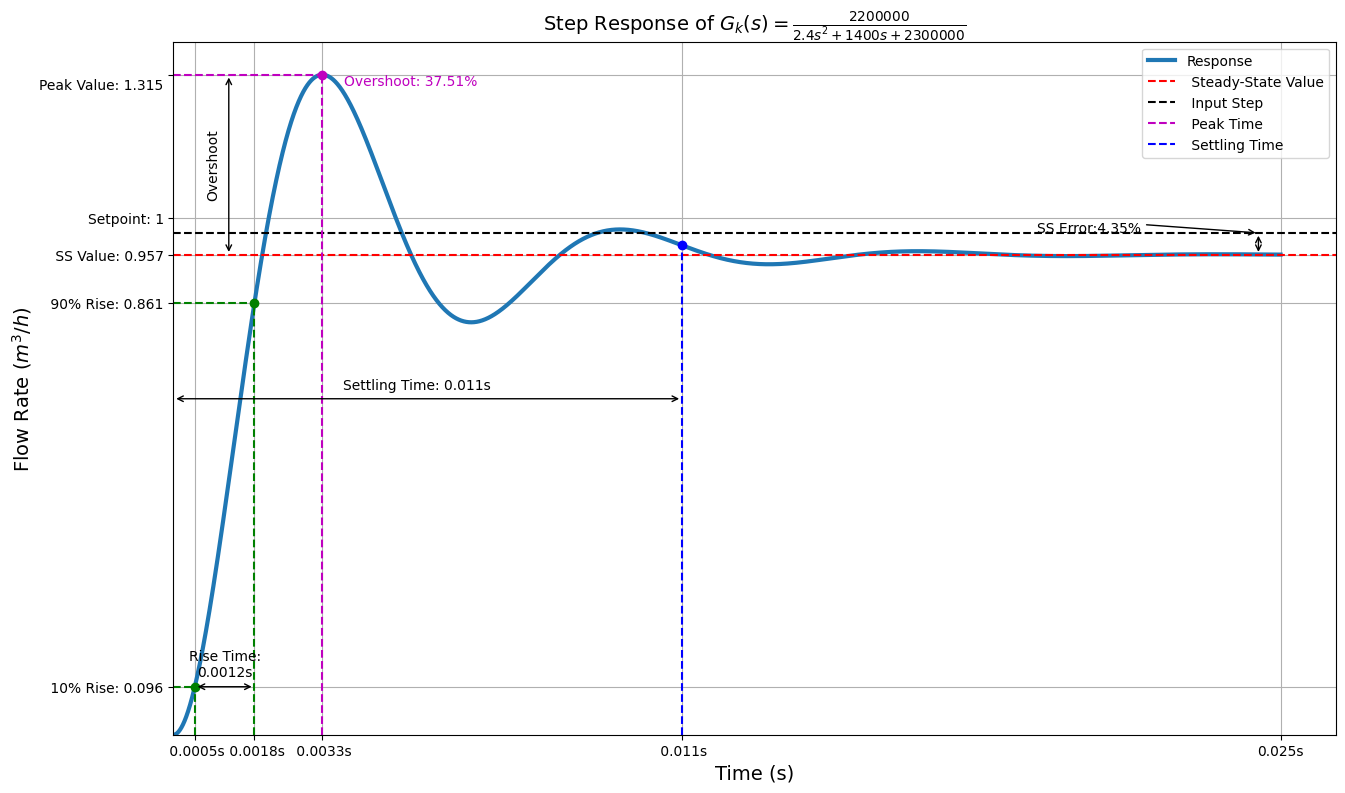

In [8]:
# @title #Open Loop Step Response
G_k = create_transfer_function()
time = generate_time_vector()
time, response = get_step_response(G_k, time)
info = ct.step_info(G_k)
plot_step_response(time, response, info, annotate=True, show_metrics=True,
                   title=r"Step Response of $G_k(s) = \frac{2200000}{2.4s^2 + 1400s + 2300000}$",
                   ylabel=r"Flow Rate ($m^3/h$)")

+---+--------------------+-------+
|   |       Metric       | Value |
+---+--------------------+-------+
| 0 |     Rise Time      | 0.021 |
| 1 |   Settling Time    | 0.039 |
| 2 |    Settling Min    | 0.901 |
| 3 |    Settling Max    |  1.0  |
| 4 |     Overshoot      |  0.0  |
| 5 |     Undershoot     |  0.0  |
| 6 |        Peak        | 0.999 |
| 7 |     Peak Time      | 0.069 |
| 8 | Steady-State Value |  1.0  |
| 9 | Steady-State Error |  0.0  |
+---+--------------------+-------+


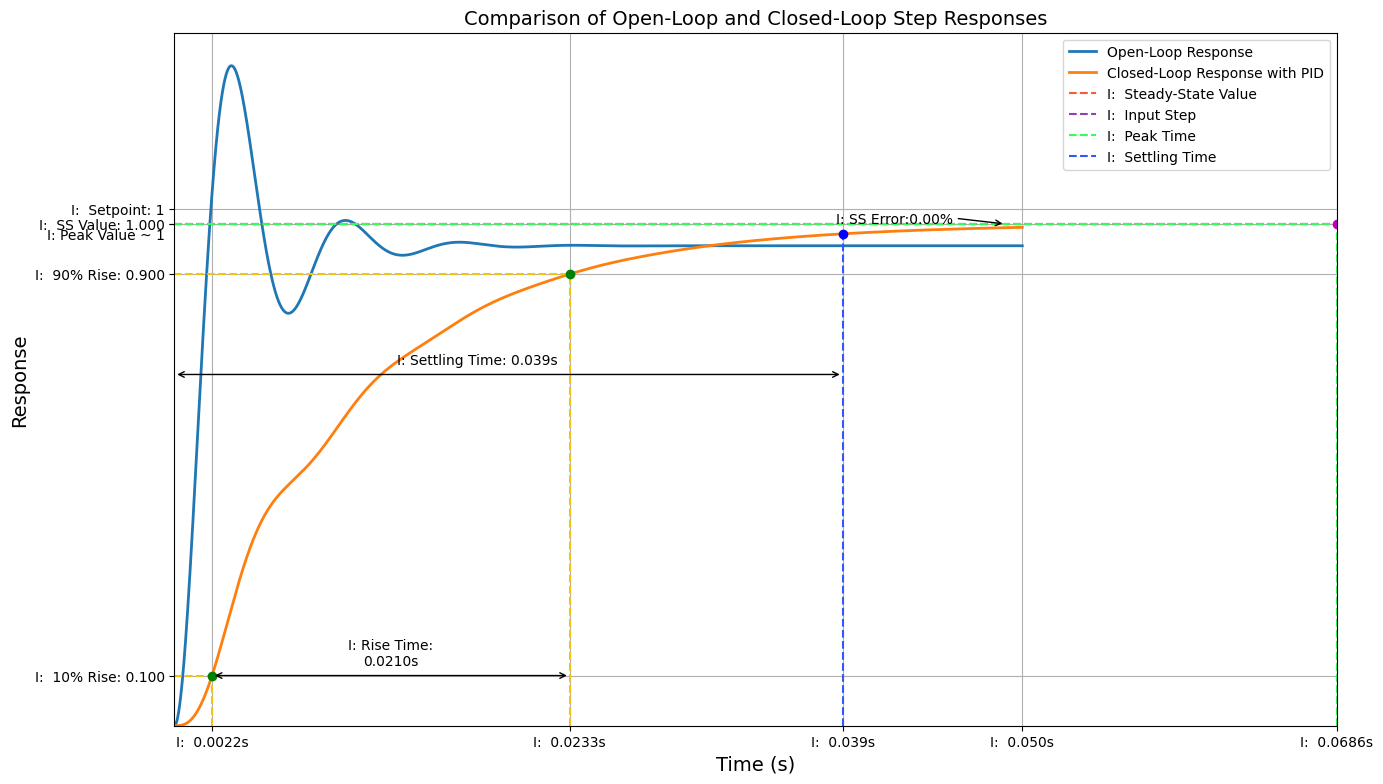

In [9]:
# @title #Try 1: I controller
Kp = 0
Ki = 100
Kd = 0
compare_open_with_PID(G_k, generate_time_vector(end=0.05), Kp=Kp, Ki=Ki, Kd=Kd, annotate_closed=True, annotate_open=False, show_closed_metrics=True, prefix='I: ')

+---+--------------------+-------+
|   |       Metric       | Value |
+---+--------------------+-------+
| 0 |     Rise Time      | 0.014 |
| 1 |   Settling Time    | 0.026 |
| 2 |    Settling Min    | 0.904 |
| 3 |    Settling Max    |  1.0  |
| 4 |     Overshoot      |  0.0  |
| 5 |     Undershoot     |  0.0  |
| 6 |        Peak        | 0.999 |
| 7 |     Peak Time      | 0.045 |
| 8 | Steady-State Value |  1.0  |
| 9 | Steady-State Error |  0.0  |
+---+--------------------+-------+


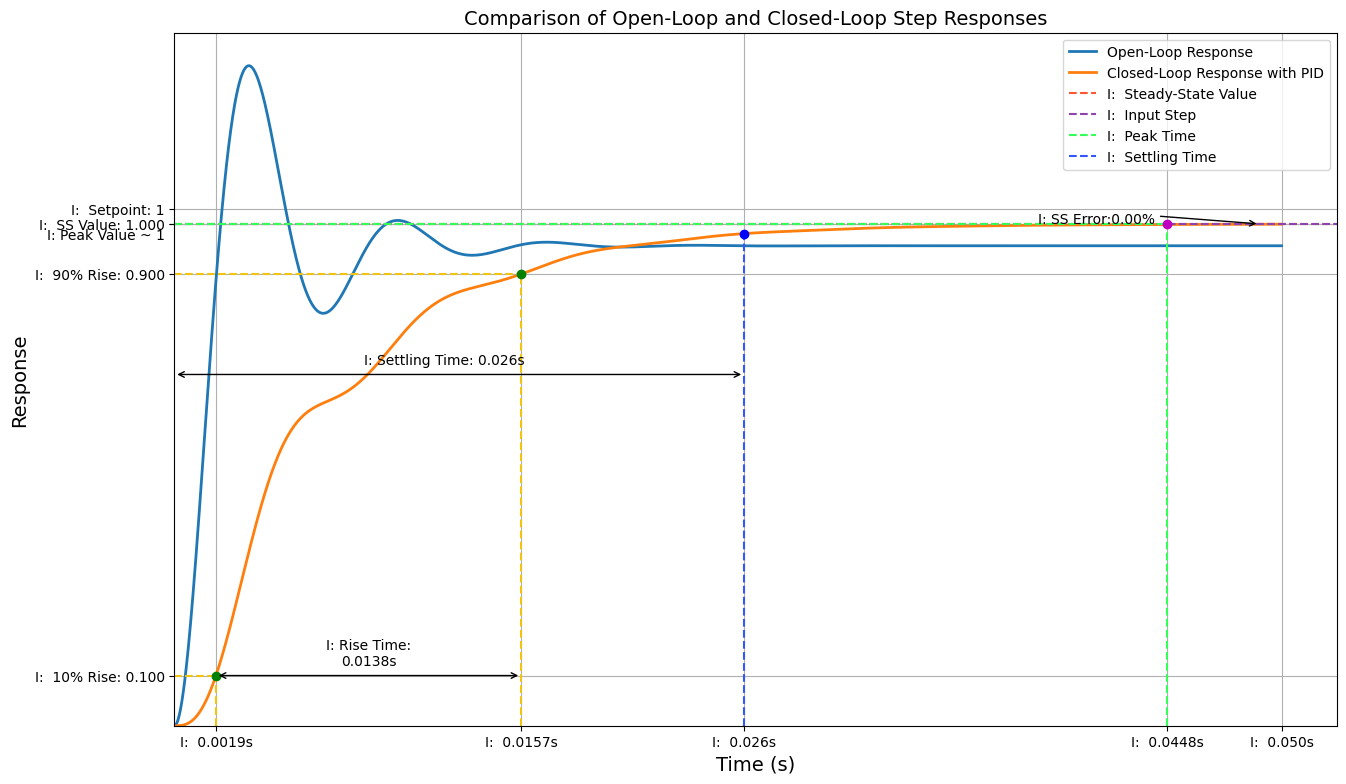

In [17]:
# @title #Try 2: I controller
Kp = 0
Ki = 150
Kd = 0
compare_open_with_PID(G_k, generate_time_vector(end=0.05), Kp=Kp, Ki=Ki, Kd=Kd, annotate_closed=True, annotate_open=False, show_closed_metrics=True, prefix='I: ')

+---+--------------------+-------+
|   |       Metric       | Value |
+---+--------------------+-------+
| 0 |     Rise Time      | 0.044 |
| 1 |   Settling Time    | 0.08  |
| 2 |    Settling Min    | 0.901 |
| 3 |    Settling Max    |  1.0  |
| 4 |     Overshoot      |  0.0  |
| 5 |     Undershoot     |  0.0  |
| 6 |        Peak        | 0.999 |
| 7 |     Peak Time      | 0.14  |
| 8 | Steady-State Value |  1.0  |
| 9 | Steady-State Error |  0.0  |
+---+--------------------+-------+


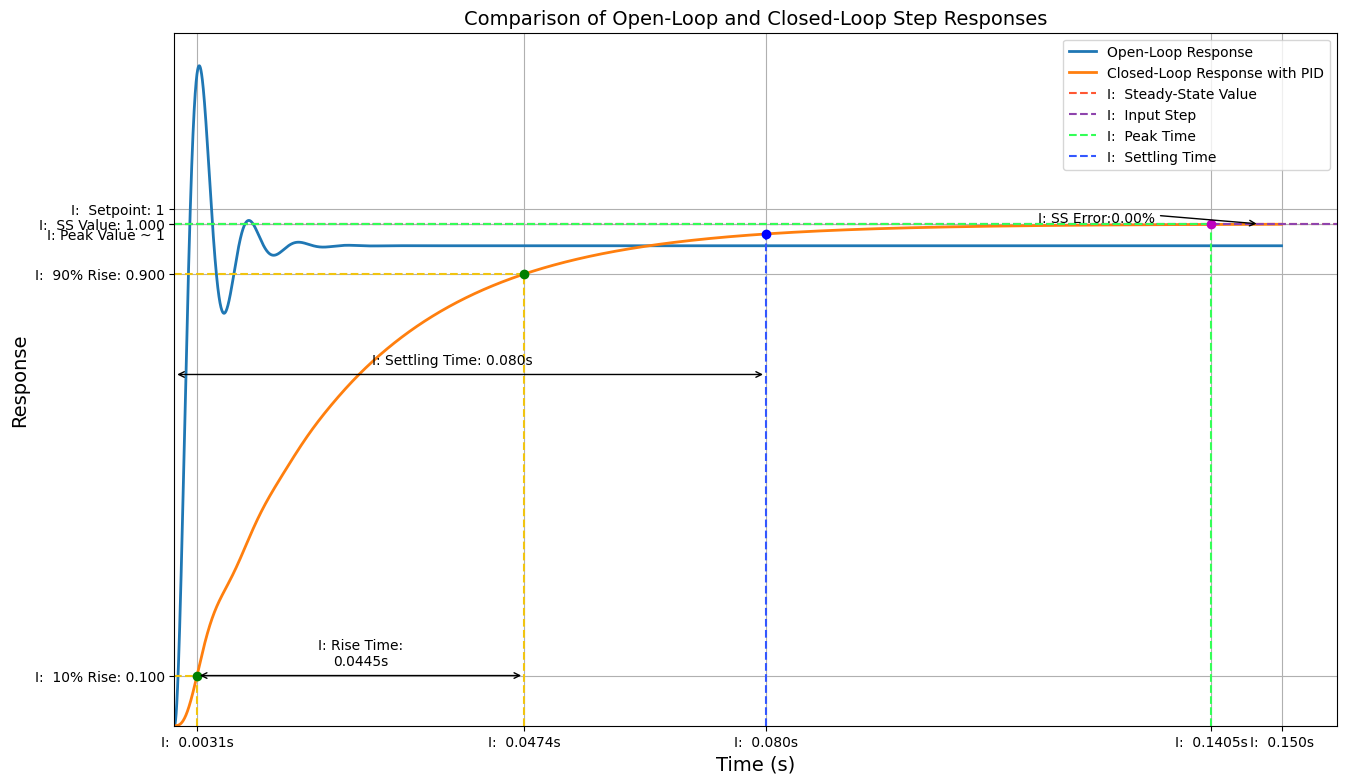

In [27]:
# @title #Try 3: I controller
Kp = 0
Ki = 50
Kd = 0
compare_open_with_PID(G_k, generate_time_vector(end=0.15), Kp=Kp, Ki=Ki, Kd=Kd, annotate_closed=True, annotate_open=False, show_closed_metrics=True, prefix='I: ')

In [ ]:
# @title #Object to get the GUI tuner for experimenting with Kp, Ki, Kd values
class PIDTuner:
    def __init__(self):
        # Create the interactive widgets
        self.create_widgets()

    def create_widgets(self):
        # PID Controller parameters
        style = {'description_width': 'initial'}

        # Create sliders
        self.kp_slider = widgets.FloatSlider(
            value=0.0, min=0, max=10, step=0.1,
            description='Kp:', style=style)
        self.ki_slider = widgets.FloatSlider(
            value=0.0, min=0, max=1000, step=0.5,
            description='Ki:', style=style)
        self.kd_slider = widgets.FloatSlider(
            value=0.0000, min=0, max=2, step=0.0001,
            description='Kd:', style=style)

        # Create increment/decrement buttons
        self.kp_inc = widgets.Button(description='+')
        self.kp_dec = widgets.Button(description='-')
        self.ki_inc = widgets.Button(description='+')
        self.ki_dec = widgets.Button(description='-')
        self.kd_inc = widgets.Button(description='+')
        self.kd_dec = widgets.Button(description='-')

        # Add button click handlers
        self.kp_inc.on_click(lambda b: self.increment_value('kp', True))
        self.kp_dec.on_click(lambda b: self.increment_value('kp', False))
        self.ki_inc.on_click(lambda b: self.increment_value('ki', True))
        self.ki_dec.on_click(lambda b: self.increment_value('ki', False))
        self.kd_inc.on_click(lambda b: self.increment_value('kd', True))
        self.kd_dec.on_click(lambda b: self.increment_value('kd', False))

        # Create layout
        kp_box = widgets.HBox([self.kp_slider, self.kp_dec, self.kp_inc])
        ki_box = widgets.HBox([self.ki_slider, self.ki_dec, self.ki_inc])
        kd_box = widgets.HBox([self.kd_slider, self.kd_dec, self.kd_inc])

        # Display widgets
        display(widgets.VBox([kp_box, ki_box, kd_box]))

        # Create the interactive plot
        self.out = widgets.interactive_output(
            self.update_plot,
            {'kp': self.kp_slider, 'ki': self.ki_slider, 'kd': self.kd_slider}
        )
        display(self.out)

    def increment_value(self, param, increase):
        # Define step sizes for each parameter
        steps = {
            'kp': 0.1,
            'ki': 1.0,
            'kd': 0.0001
        }

        # Get current value and step size
        slider = getattr(self, f'{param}_slider')
        step = steps[param]

        # Update value
        if increase:
            new_value = min(slider.max, slider.value + step)
        else:
            new_value = max(slider.min, slider.value - step)

        slider.value = new_value

    def get_closed_loop_response(self, kp, ki, kd):
        # Time vector
        t = generate_time_vector(end=1, num_points=1000)

        # Plant transfer function G(s)
        G_k = create_transfer_function()

        # PID controller transfer function C(s)
        num_C = [kd, kp, ki]
        den_C = [1, 0]
        C = ct.TransferFunction(num_C, den_C)

        # Closed loop transfer function T(s) = C(s)G_k(s)/(1 + C(s)G_k(s))
        sys_ol = C * G_k  # Open loop transfer function
        sys_cl = ct.feedback(sys_ol, 1)  # Closed loop transfer function

        # Compute step response
        time, response = ct.step_response(sys_cl, t)

        # Calculate performance metrics
        info = { }

        # Steady state value
        info['SteadyStateValue'] = response[-1]

        # Find settling time (time to reach and stay within 2% of final value)
        settling_band = 0.02 * info['SteadyStateValue']
        settling_idx = np.where(np.abs(response - info['SteadyStateValue']) <= settling_band)[0][0]
        info['SettlingTime'] = time[settling_idx]

        # Find peak and calculate overshoot
        info['Peak'] = np.max(response)
        peak_idx = np.argmax(response)
        info['PeakTime'] = time[peak_idx]
        info['Overshoot'] = (info['Peak'] - 1) / 1 * 100 if info['Peak'] > 1 else 0

        # Calculate rise time (time to go from 10% to 90% of final value)
        rise_start = np.interp(0.1, response, time)
        rise_end = np.interp(0.9, response, time)
        info['RiseTime'] = rise_end - rise_start

        return time, response, info

    def update_plot(self, kp, ki, kd):
        fig, ax = plt.subplots(figsize=(12, 6))

        # Get system response
        time, response, info = self.get_closed_loop_response(kp, ki, kd)

        ax.set_ylim(bottom=0)
        ax.set_xlim(left=0)

        # Plot response
        ax.plot(time, response, 'b-', label='Closed Loop Response', linewidth=1)

        # Add annotations using the provided function
        annotate_step_response(ax, time, response, info, color_set_index=1)

        plt.xlabel('Time (s)')
        plt.ylabel('Output')
        plt.grid(True)
        plt.legend()
        plt.show()

In [ ]:
# @title #Create and display the tuner
tuner = PIDTuner()

Output()

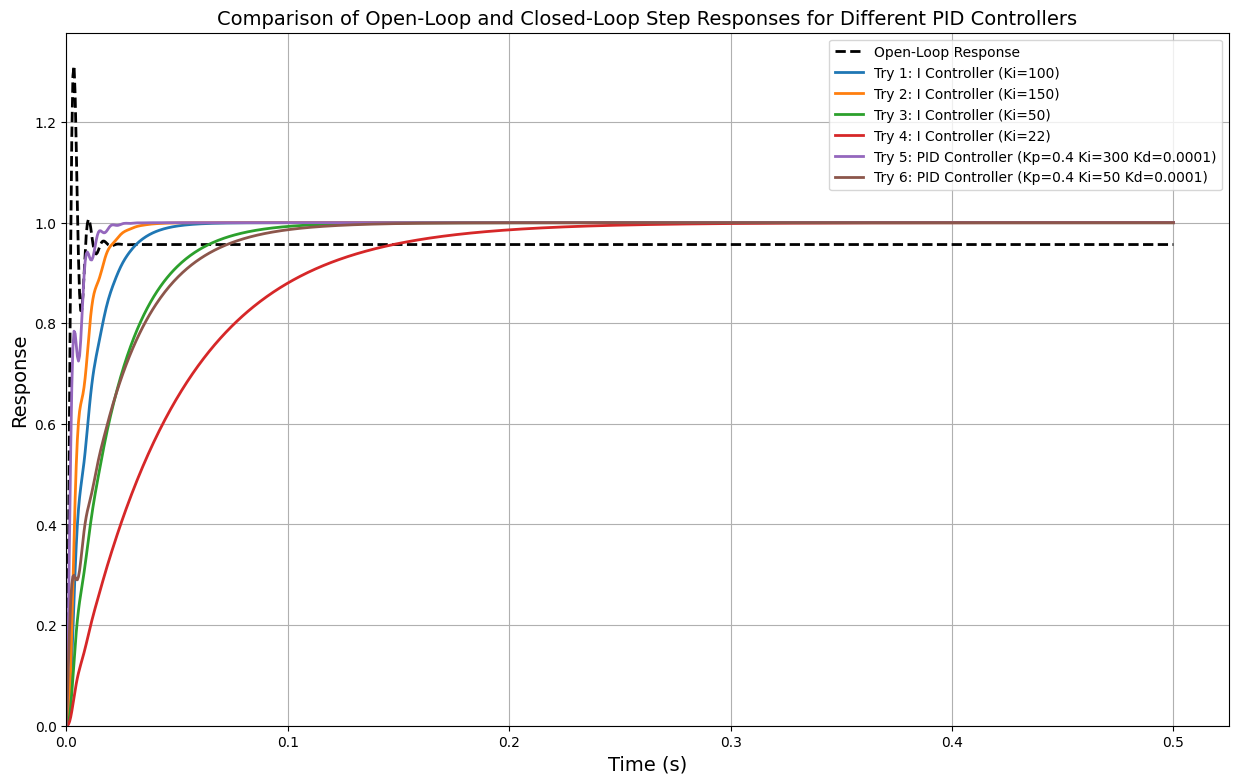

In [38]:
# @title #Function to plot multiple PID responses for given gains
def compare_multiple_pid_responses(G_k, time_vector, pid_parameters_list):
    """
    Compare and plot open loop and closed loop step responses for multiple sets of PID controller gains.

    Parameters:
    - G_k: Transfer function of the plant.
    - time_vector: Array of time values.
    - pid_parameters_list: List of dictionaries with keys 'Kp', 'Ki', 'Kd', and optionally 'label'.
    """
    # Plot open-loop response for reference
    time_open, response_open = ct.step_response(G_k, T=time_vector)
    plt.figure(figsize=(15, 9))
    plt.plot(time_open, response_open, linewidth=2, label='Open-Loop Response', linestyle='--', color='black')

    # Loop over each set of PID gains and plot the closed-loop response
    for idx, pid_params in enumerate(pid_parameters_list):
        Kp = pid_params.get('Kp', 0)
        Ki = pid_params.get('Ki', 0)
        Kd = pid_params.get('Kd', 0)
        label = pid_params.get('label', f'Try {idx + 1}: PID(Kp={Kp}, Ki={Ki}, Kd={Kd})')

        # Create the PID controller transfer function
        controller = ct.TransferFunction([Kd, Kp, Ki], [1, 0])

        # Closed-loop transfer function with unity feedback
        G_cl = ct.feedback(controller * G_k, 1)

        # Compute the step response
        time_closed, response_closed = ct.step_response(G_cl, T=time_vector)

        # Plot the closed-loop response
        plt.plot(time_closed, response_closed, linewidth=2, label=label)

    # Plot formatting
    plt.title('Comparison of Open-Loop and Closed-Loop Step Responses for Different PID Controllers', fontsize=14)
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Response', fontsize=14)
    plt.grid(True)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.legend()
    plt.show()

# Example usage of the function
G_k = create_transfer_function()
time_vector = generate_time_vector(end=0.5, num_points=1000)

# List of PID parameters to test
pid_parameters_list = [
    {'Kp': 0, 'Ki': 100, 'Kd': 0, 'label': 'Try 1: I Controller (Ki=100)'},
    {'Kp': 0, 'Ki': 150, 'Kd': 0, 'label': 'Try 2: I Controller (Ki=150)'},
    {'Kp': 0, 'Ki': 50, 'Kd': 0, 'label': 'Try 3: I Controller (Ki=50)'},
    {'Kp': 0, 'Ki': 22, 'Kd': 0, 'label': 'Try 4: I Controller (Ki=22)'},
    {'Kp': 0.4, 'Ki': 300, 'Kd': 0.0001, 'label': 'Try 5: PID Controller (Kp=0.4 Ki=300 Kd=0.0001)'},
    {'Kp': 0.2, 'Ki': 50, 'Kd': 0.0001, 'label': 'Try 6: PID Controller (Kp=0.4 Ki=50 Kd=0.0001)'},
]

# Plot all responses
compare_multiple_pid_responses(G_k, time_vector, pid_parameters_list)
